# Laboratorium

### Konfiguracja

In [136]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import pandas as pd
from random import uniform
from sortedcontainers import SortedSet
from heapq import heapify, heappop
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przygotuj procedurę, pozwalającą wprowadzać w sposób interaktywny kolejne odcinki (reprezentowane przez pary wierzchołków), a także generować losowo zadaną liczbę odcinków z podanego zakresu współrzędnych 2D. Odcinki pionowe powinny być eliminowane i żadna para odcinków nie powinna mieć końców odcinków o tej samej współrzędnej x. Program powinien umożliwiać zapis i odczyt zbioru odcinków

In [3]:
%matplotlib notebook
def save_to_file(file_name, lines):
    with open(f"{file_name}.json", "w") as f:
        f.write(f"lines: {lines}")
        
def load_from_file(file_name):
    with open(f"{file_name}.json", "r") as f:
        data = f.readlines()
    return data
def get_lines(plot):
    lines = plot.get_added_lines()
    result = []
    for l in lines:
        result += l.lines
    tuple_result = []
    for line in result:
        new_line = (line[0], line[1])
        tuple_result.append(new_line)
    return tuple_result
def generate_lines(n, left, right):
    lines = []
    points = set()
    i = 0
    while i < n:
        point1 = (uniform(left[0], right[0]), uniform(left[1], right[1]))
        point2 = (uniform(left[0], right[0]), uniform(left[1], right[1]))
        if point1[0] != point2[0] and point1[0] not in points and point2[0] not in points:
            if point1[0] < point2[0]:
                lines.append((point1, point2))
            else:
                lines.append((point2, point1))
            points.add(point1[0])
            points.add(point2[0])
            i+=1 
    return lines

<IPython.core.display.Javascript object>


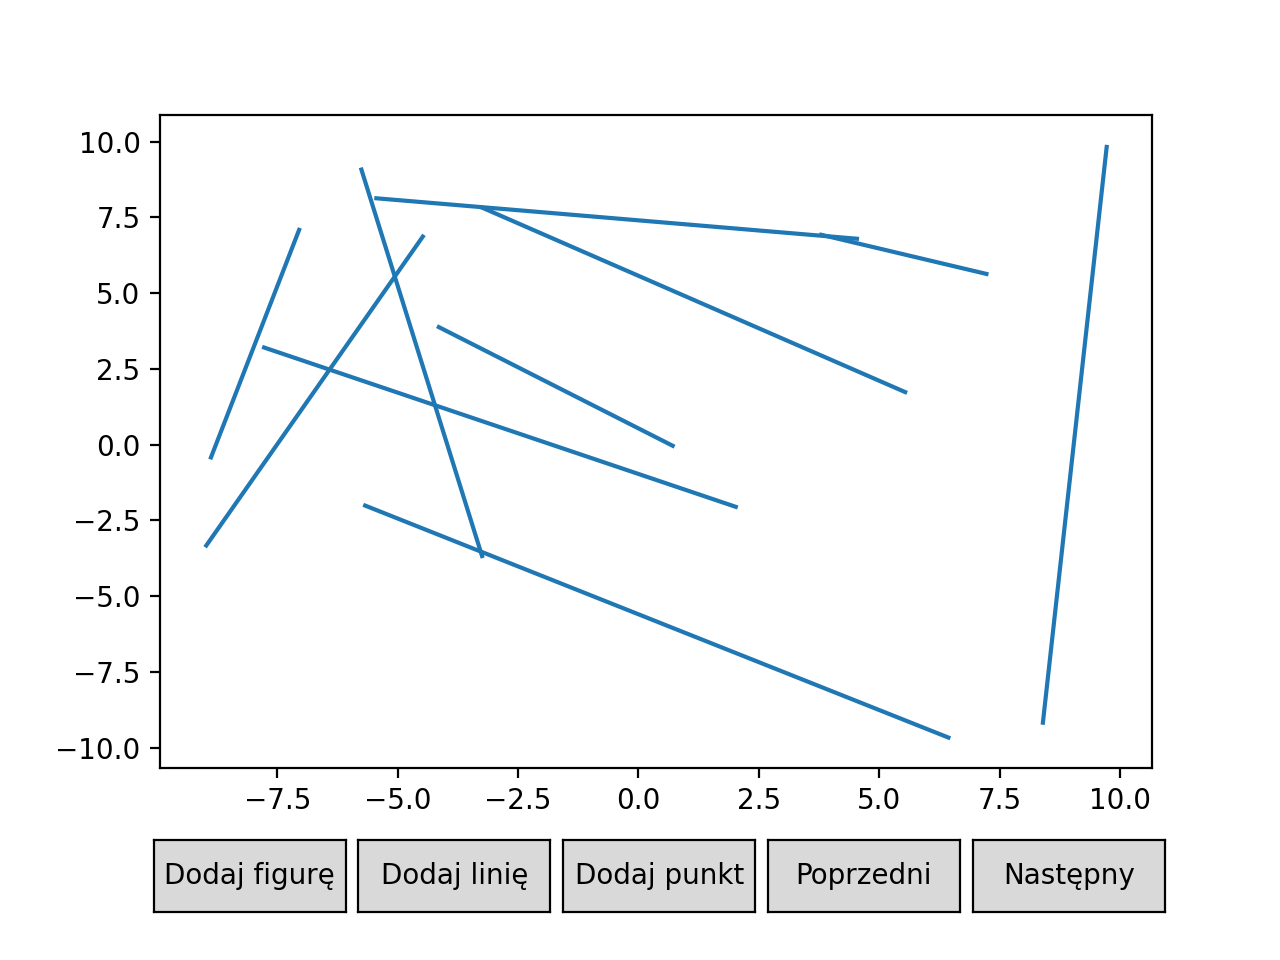

In [4]:
lines1 = generate_lines(10, (-10, -10), (10, 10))
plot = Plot([Scene(lines=[LinesCollection(lines1)])])
plot.draw()

### Zaimplementuj algorytm zamiatania sprawdzający, czy choć jedna para odcinków w zadanym zbiorze się przecina

In [5]:
def det(a,b,c):
    deta = a[0]*b[1] + b[0]*c[1] + a[1]*c[0]
    detb = c[0]*b[1] + c[1]*a[0] + b[0]*a[1]
    det = deta-detb
    return det
def orient(a, b, c, epsilon=10 ** (-12)):
    deter = det(a,b,c)
    if deter > epsilon:
        return 1
    elif deter < -epsilon:
        return -1
    return 0

In [122]:
def punkcik(x,y):
    x_a = (x[0][1]-x[1][1])/(x[0][0]-x[1][0])
    x_b = (x[0][1] - x[0][0]*x_a)
    y_a = (y[0][1]-y[1][1])/(y[0][0]-y[1][0])
    y_b = (y[0][1] - y[0][0]*y_a)
    p_x = (x_b-y_b)/(y_a-x_a)
    p_y = x_a*p_x + x_b
    return (p_x,p_y)
def przeciecie(line1, line2):
    o1 = orient(line1[0], line1[1], line2[0])
    o2 = orient(line1[0], line1[1], line2[1])

    o3 = orient(line2[0], line2[1], line1[0])
    o4 = orient(line2[0], line2[1], line1[1])

    return o1 != o2 and o3 != o4
def add_line(sorted_lines,line,scenes,lines,min_y,max_y):
    sorted_lines.add(line)
    index = list(sorted_lines).index(line)
    
    if index - 1 >= 0 or index + 1 < len(sorted_lines):
        line_previous = sorted_lines[index - 1]
        temp = przeciecie(line_previous, line)
        if(temp):
            point = punkcik(line_previous,line)
            scenes.append(Scene(
                [PointsCollection([line[0]], color='red'),
                 PointsCollection([point], color='red', zorder = 2)],
                [LinesCollection(lines , zorder = 1),
                 LinesCollection([(line[0], line[1])], color='green'),
                 LinesCollection([((line[0][0], min_y), (line[0][0], max_y))], color='red')]))
        return temp
    
def remove_line(sorted_lines,line,scenes,lines,min_y,max_y):
    index = list(sorted_lines).index(line)
    
    if index - 1 >= 0 and index + 1 < len(sorted_lines):
        line_previous = sorted_lines[index - 1]
        line_next = sorted_lines[index + 1]
        temp = przeciecie(line_previous, line_next)
        if(temp):
            point = punkcik(line_previous,line_next)
            scenes.append(Scene(
                [PointsCollection([line[1]], color='red'),
                 PointsCollection([point], color='red', zorder = 2)],
                [LinesCollection(lines, zorder = 1),
                 LinesCollection([(line[0], line[1])], color='green'),
                 LinesCollection([((line[1][0], min_y), (line[1][0], max_y))], color='red')]))
        return temp
    else:
        sorted_lines.pop(index)
        
def state(event,scenes,lines,min_y,max_y,sorted_lines):
    if event[0] == event[1][0][0]:
        scenes.append(Scene(
                [PointsCollection([event[1][0]], color='red')],
                [LinesCollection(lines),
                 LinesCollection([(event[1][0], event[1][1])], color='green'),
                 LinesCollection([((event[0], min_y), (event[0], max_y))], color='red')]))
        return add_line(sorted_lines,event[1],scenes,lines,min_y,max_y)
    else:
        scenes.append(Scene(
            [PointsCollection([event[1][1]], color='red')],
            [LinesCollection(lines),
             LinesCollection([(event[1][0], event[1][1])], color='green'),
             LinesCollection([((event[0], min_y), (event[0], max_y))], color='red')]))
        return remove_line(sorted_lines,event[1],scenes,lines,min_y,max_y)
def Miotła(lines):
    scenes = []
    events = []
    sorted_lines = SortedSet(key=lambda x: x[0][1])
    min_y_1 = min(lines,key = lambda y: y[0][1])[0][1]
    max_y_1 = max(lines,key = lambda y: y[0][1])[0][1]
    min_y_2 = min(lines,key = lambda y: y[1][1])[1][1]
    max_y_2 = max(lines,key = lambda y: y[1][1])[1][1]
    min_y = min(min_y_1,min_y_2)
    max_y = max(max_y_1,max_y_2)
    for line in lines:
        events.append((line[0][0], line))
        events.append((line[1][0], line))
    heapify(events)
    while len(events) > 0:
        current_event = heappop(events)
        if state(current_event,scenes,lines,min_y,max_y,sorted_lines):
            return scenes
    return scenes

### Przetestuj program na różnych zestawach danych

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


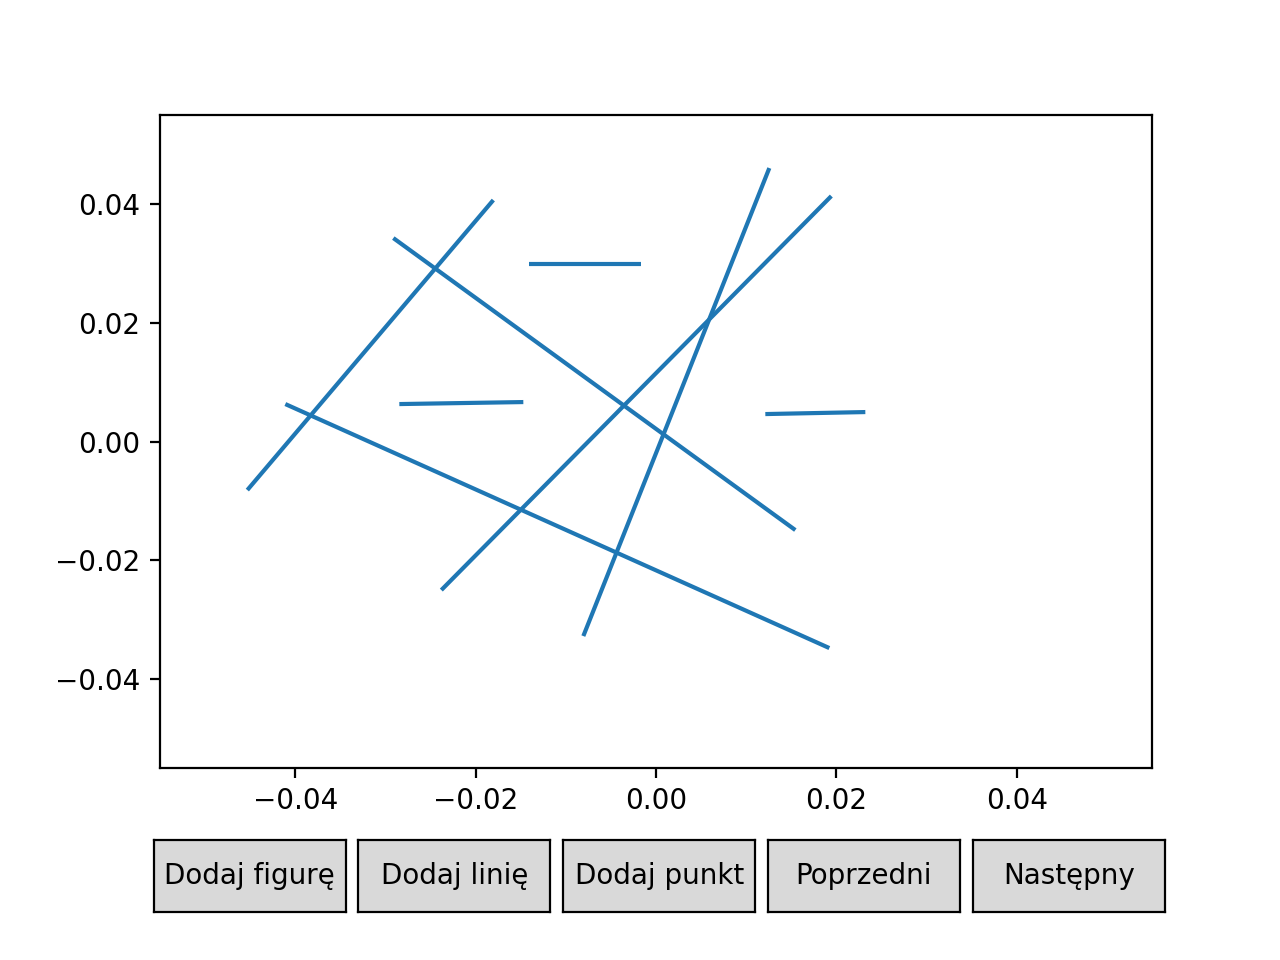

In [7]:
plot = Plot()
plot.draw()

In [8]:
lines = get_lines(plot)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


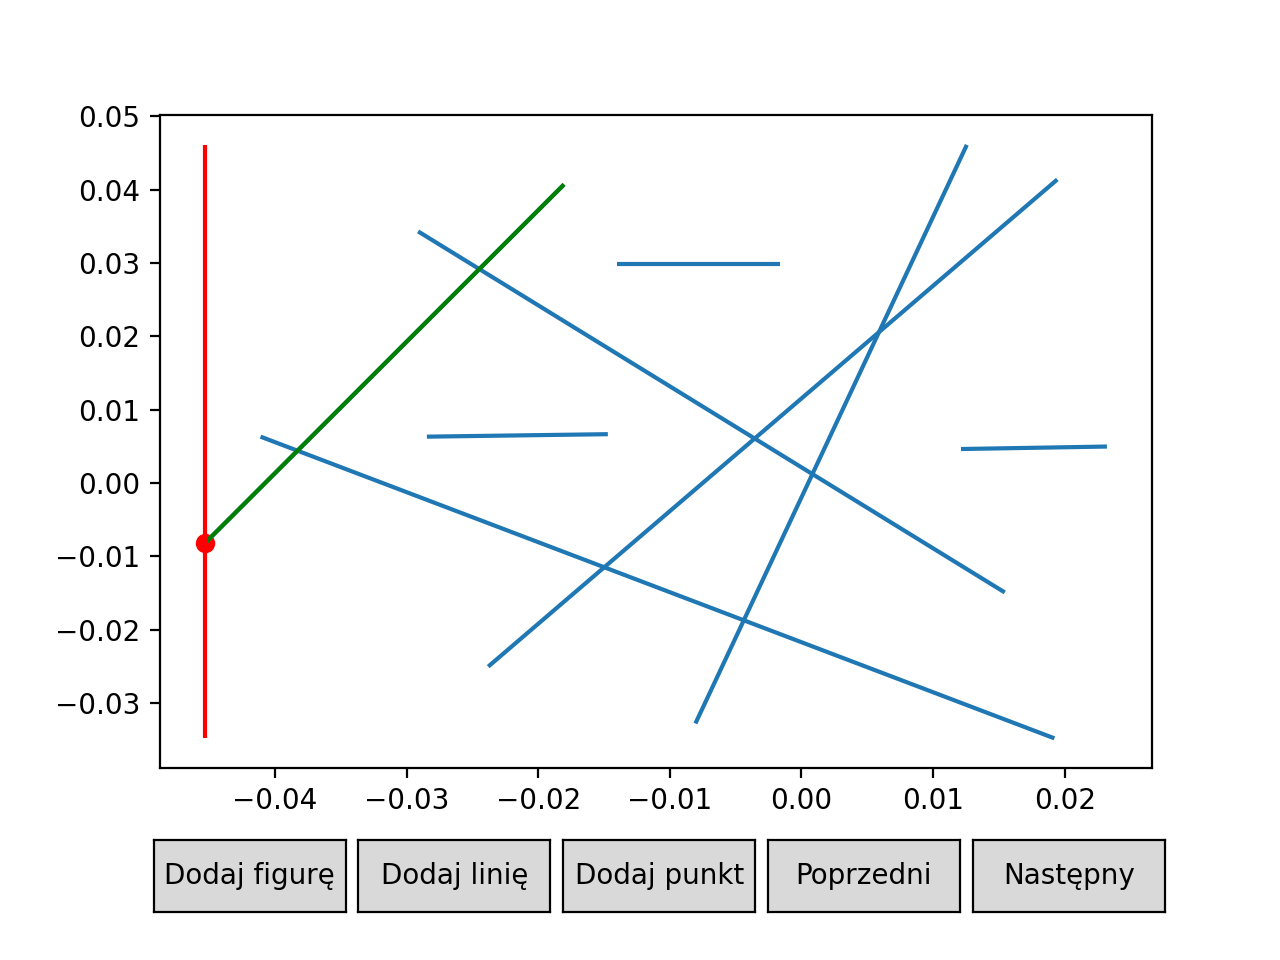

In [118]:
broom = Miotła(lines)
plot = Plot(broom)
plot.draw()

<IPython.core.display.Javascript object>


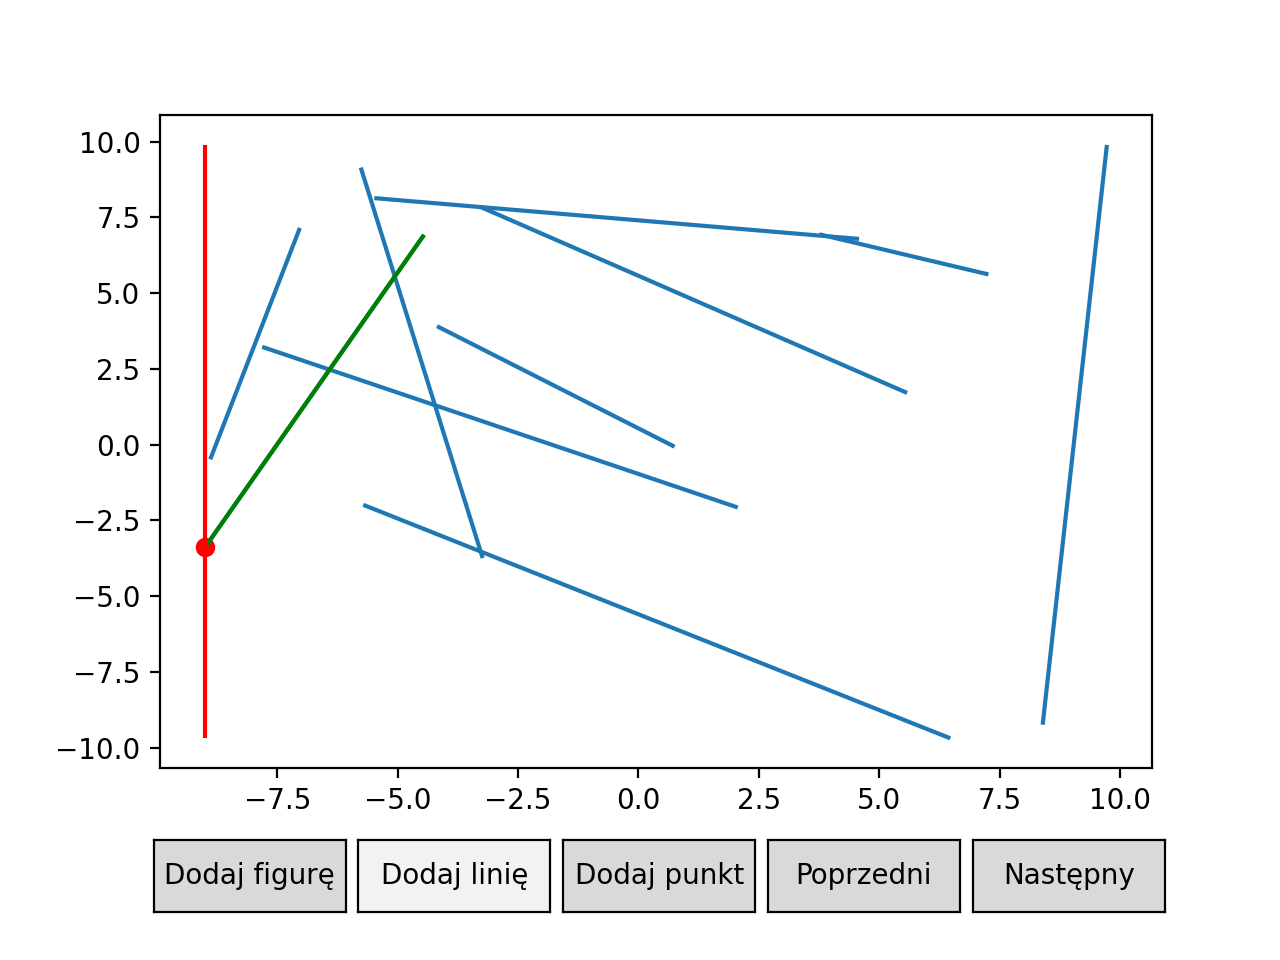

In [123]:
broom1 = Miotła(lines1)
plot1 = Plot(broom1)
plot1.draw()


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


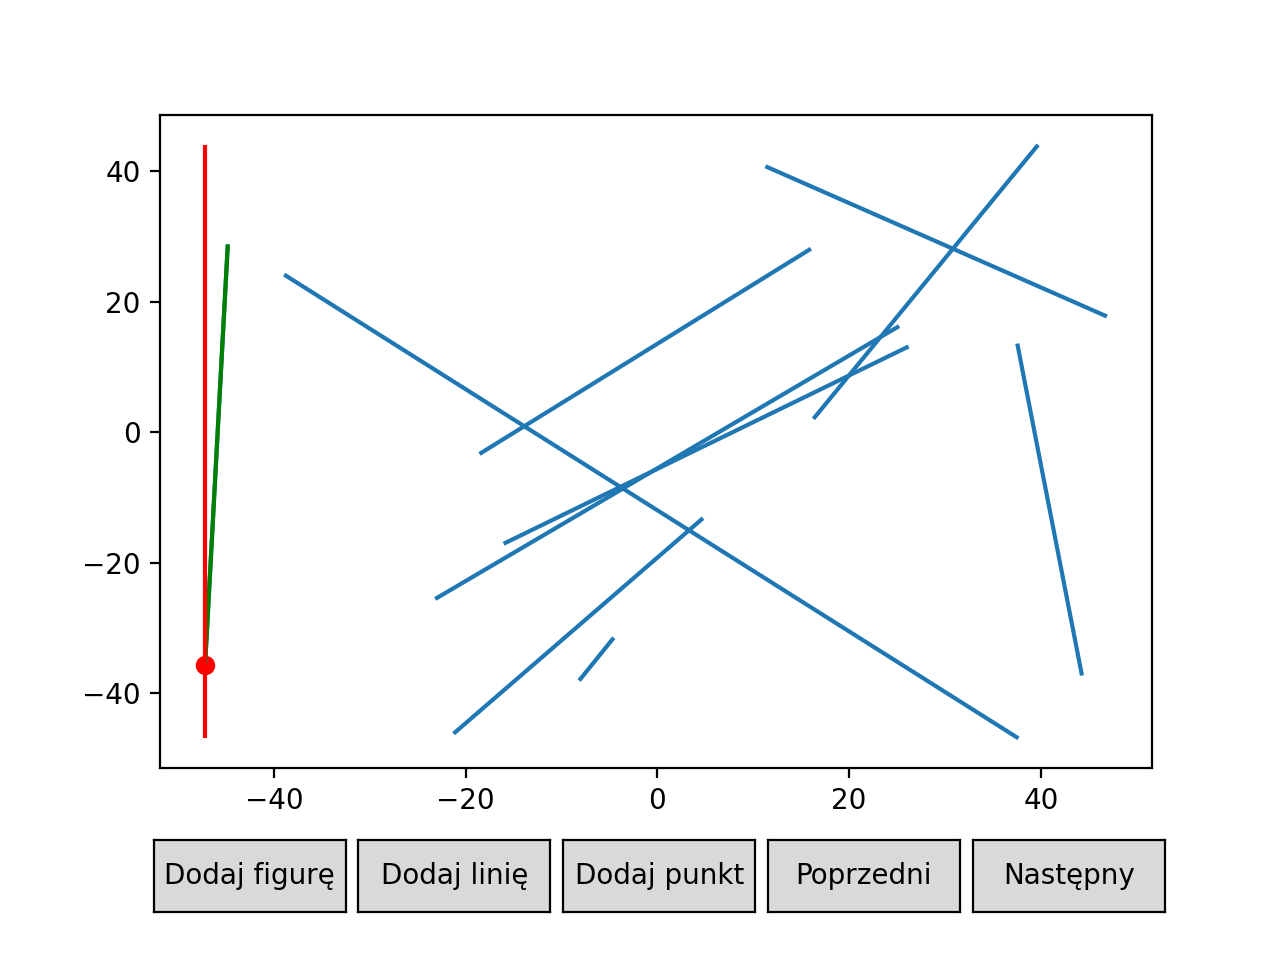

In [124]:
lines2 = generate_lines(10, (-50, -50), (50, 50))
broom2 = Miotła(lines2)
plot2 = Plot(broom2)
plot2.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


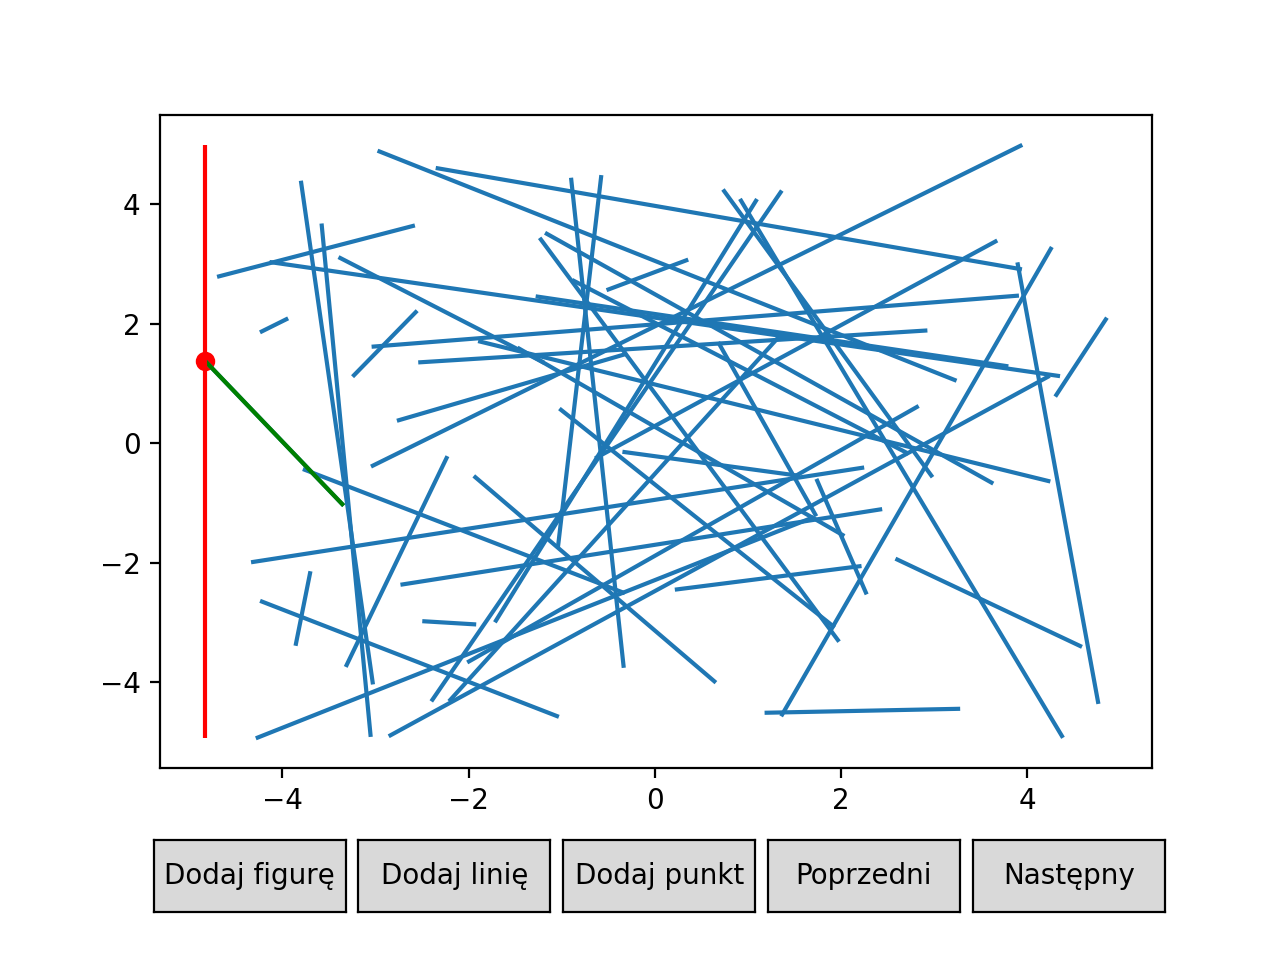

In [125]:
lines3 = generate_lines(50, (-5, -5), (5, 5))
broom3 = Miotła(lines3)
plot3 = Plot(broom3)
plot3.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


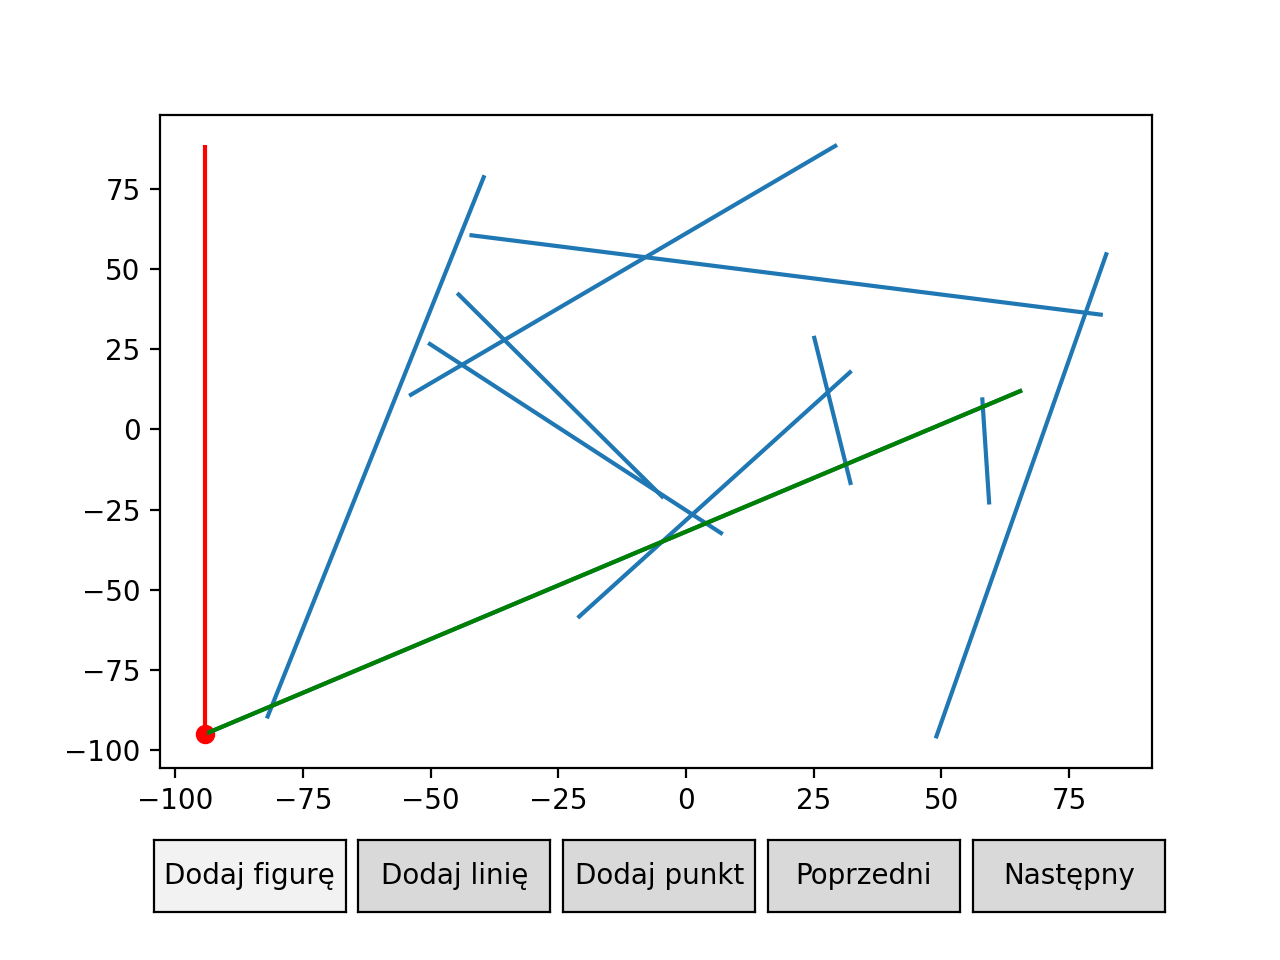

In [126]:
lines4 = generate_lines(10, (-100, -100), (100,100))
broom4 = Miotła(lines4)
plot4 = Plot(broom4)
plot4.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


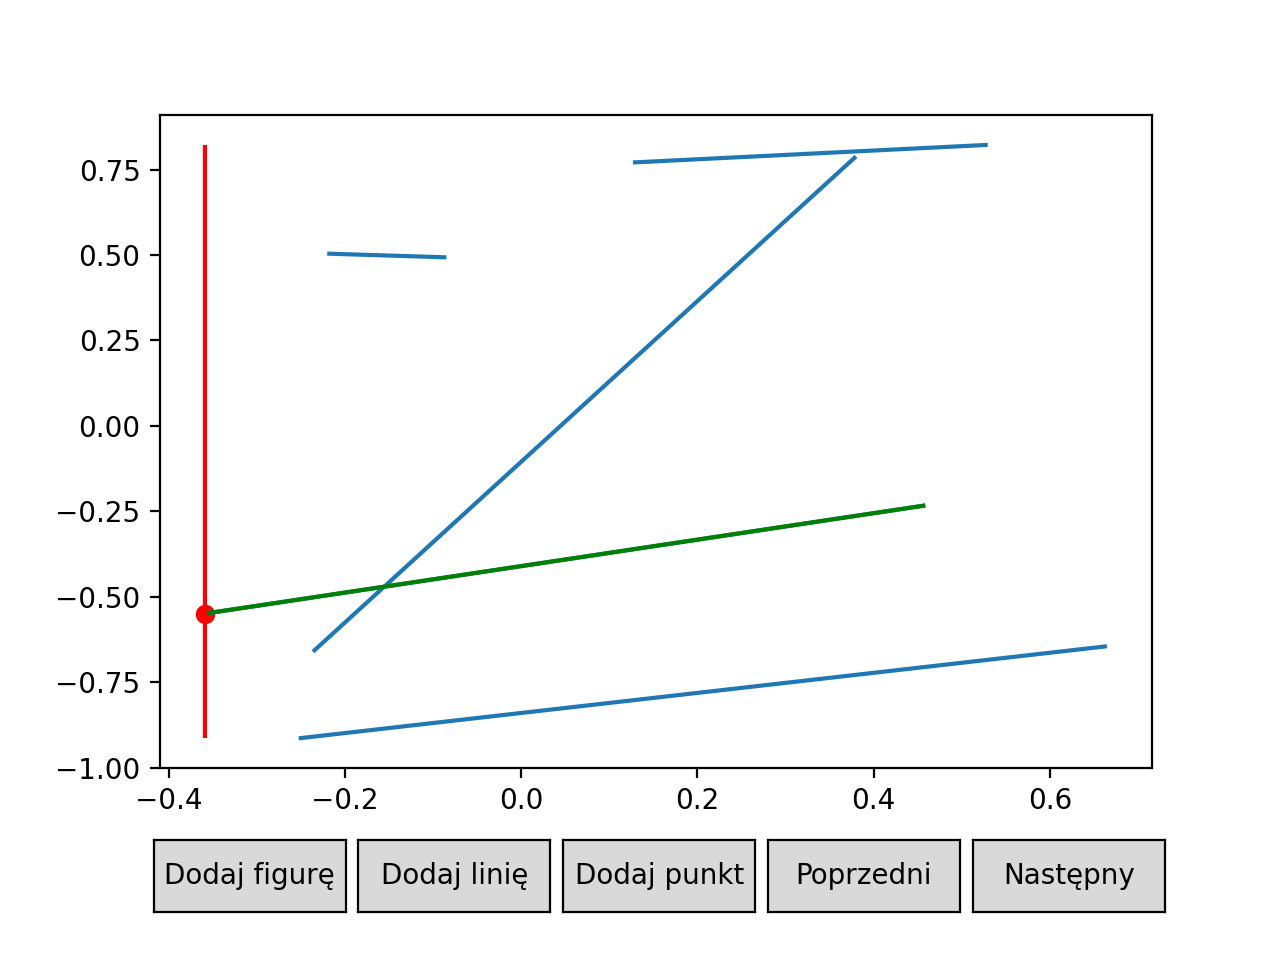

In [127]:
lines5 = generate_lines(5, (-1, -1), (1, 1))
broom5 = Miotła(lines5)
plot5 = Plot(broom5)
plot5.draw()

### Odpowiednio modyfikując program zaimplementuj algorytm wyznaczający wszystkie przecięcia odcinków. Na wyjściu program powinien podawać liczbę wykrytych przecięć, współrzędne przecięć oraz dla każdego przecięcia odcinki, które się przecinają. Zmodyfikuj (jeśli to konieczne) procedurę wizualizacji dla tego zagadnienia. 

In [128]:
def punkcik(x,y):
    x_a = (x[0][1]-x[1][1])/(x[0][0]-x[1][0])
    x_b = (x[0][1] - x[0][0]*x_a)
    y_a = (y[0][1]-y[1][1])/(y[0][0]-y[1][0])
    y_b = (y[0][1] - y[0][0]*y_a)
    p_x = (x_b-y_b)/(y_a-x_a)
    p_y = x_a*p_x + x_b
    return (p_x,p_y)
def przeciecie2(line1, line2):
    o1 = orient(line1[0], line1[1], line2[0])
    o2 = orient(line1[0], line1[1], line2[1])

    o3 = orient(line2[0], line2[1], line1[0])
    o4 = orient(line2[0], line2[1], line1[1])

    if o1 != o2 and o3 != o4:
        return punkcik(line1,line2)
    return None 

In [142]:
class Linsy:
    def __init__(self, line1, line2):
        self.line1 = line1
        self.line2 = line2
def to_order(line,x):
    a = (line[1][1] - line[0][1]) / (line[1][0] - line[0][0])
    b = line[1][1] - a * line[1][0]
    return a * x + b
# def swap(line,sorted_lines,events,inter,dict_info,intersection_lines,i):
#     sorted_lines[i] = line
#     index = i    
#     if index - 1 >= 0:
#         intersection = przeciecie2(sorted_lines[index - 1], line)
#         l1,l2 = sorted_lines[index - 1], line
#         dict_info[intersection] = Linsy(l1,l2)
#         if intersection is not None and (l1,l2) not in intersection_lines and (l2,l1) not in intersection_lines:
#             events.add(intersection)
#             intersection_lines.add((l1, l2))   
    
#     if index + 1 < len(sorted_lines):
#         intersection = przeciecie2(line, sorted_lines[index + 1])
#         l1,l2 = line, sorted_lines[index + 1]
#         dict_info[intersection] = Linsy(l1,l2)
#         if intersection is not None and (l1,l2) not in intersection_lines and (l2,l1) not in intersection_lines:
#             events.add(intersection)
#             intersection_lines.add((l1, l2))
def add_line2(line,sorted_lines,events,inter,dict_info,intersection_lines):
    sorted_lines.add(line)
#     sorted_lines.append(line)
    index = list(sorted_lines).index(line)   
    if index - 1 >= 0:
        intersection = przeciecie2(sorted_lines[index - 1], line)
        l1,l2 = sorted_lines[index - 1], line
        if intersection is not None and (l1,l2) not in intersection_lines and (l2,l1) not in intersection_lines:
            events.add(intersection)
            dict_info[intersection] = Linsy(l1,l2)
            intersection_lines.add((l1, l2))   
    
    if index + 1 < len(sorted_lines):
        intersection = przeciecie2(line, sorted_lines[index + 1])
        l1,l2 = line, sorted_lines[index + 1]
        if intersection is not None and (l1,l2) not in intersection_lines and (l2,l1) not in intersection_lines:
            events.add(intersection)
            dict_info[intersection] = Linsy(l1,l2)
            intersection_lines.add((l1, l2))
    
def remove_line2(line,sorted_lines,events,inter,dict_info,intersection_lines): 
    index = list(sorted_lines).index(line)
    if index - 1 >= 0 and index + 1 < len(sorted_lines):
        intersection = przeciecie2(sorted_lines[index - 1], sorted_lines[index + 1])
        l1,l2 = sorted_lines[index - 1], sorted_lines[index + 1]
        if intersection is not None and (l1,l2) not in intersection_lines and (l2,l1) not in intersection_lines:
            events.add(intersection)
            dict_info[intersection] = Linsy(l1, l2)
            intersection_lines.add((l1, l2))
    sorted_lines.pop(index)
def Miotła_2(lines):
    scenes = []
    events = SortedSet(key=lambda x: -x[0])
    sorted_lines = SortedSet()
#     sorted_lines = []
    info_lines = dict()
    intersection = set()
    dict_info = dict()
    intersection_lines = set()
    
    for line in lines:
        info_lines[line[0]] = line
        info_lines[line[1]] = line
        events.add(line[0])
        events.add(line[1])
        
    min_y = min(list(info_lines.keys()),key = lambda y: y[1])[1]
    max_y = max(list(info_lines.keys()),key = lambda y: y[1])[1]

    while len(events) > 0:
        event = events.pop()
        
        if event in info_lines:
            scenes.append(Scene([PointsCollection([event], color="red", zorder=10),
                                  PointsCollection(list(intersection), color="red", zorder=10)],
                                 [LinesCollection(lines),
                                  LinesCollection([info_lines[event]], color='green'),
                                  LinesCollection([((event[0], min_y), (event[0], max_y))], color="red", zorder=10)]))
            info_line = info_lines[event]
            active_lines = SortedSet(key=lambda line: to_order(line,event[0]))
            active_lines.update(sorted_lines)
            sorted_lines = active_lines
            if event == info_line[0]:
#                 print('add')
                add_line2(info_line,sorted_lines,events,intersection,dict_info,intersection_lines)
               
            else:
#                 print('remove')
                remove_line2(info_line,sorted_lines,events,intersection,dict_info,intersection_lines)
        else:
            scenes.append(Scene([PointsCollection([event], color="red", zorder=10),
                              PointsCollection(list(intersection), color="red", zorder=10)],
                             [LinesCollection(lines),
                              LinesCollection([((event[0], min_y), (event[0], max_y))], color="red", zorder=10)]))
#             print("intersection")
            intersection.add(event)
            line1 = dict_info[event].line1
            line2 = dict_info[event].line2
#             index1 = list(sorted_lines).index(line1)
#             index2 = list(sorted_lines).index(line2)
#             print(index1,index2)
#             print(sorted_lines[index1])
#             print(sorted_lines[index2])
#             swap(line1,sorted_lines,events,intersection,dict_info,intersection_lines,index2)
#             swap(line2,sorted_lines,events,intersection,dict_info,intersection_lines,index1)
#             print(sorted_lines[index1])
#             print(sorted_lines[index2])
            remove_line2(line1,sorted_lines,events,intersection,dict_info,intersection_lines)
            remove_line2(line2,sorted_lines,events,intersection,dict_info,intersection_lines)
            active_lines = SortedSet(key=lambda line: to_order(line,event[0] + 10**(-12)))
            active_lines.update(sorted_lines)
            sorted_lines = active_lines
            
            add_line2(line1,sorted_lines,events,intersection,dict_info,intersection_lines)
            add_line2(line2,sorted_lines,events,intersection,dict_info,intersection_lines)
    scenes.append(Scene([PointsCollection(list(intersection), color="red", zorder=10)],
                         [LinesCollection(lines)]))
           
    return scenes,[*list(intersection)],dict_info,intersection_lines




### Przetestuj zmodyfikowany program na różnych zestawach danych

Ilość przecięć 7


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


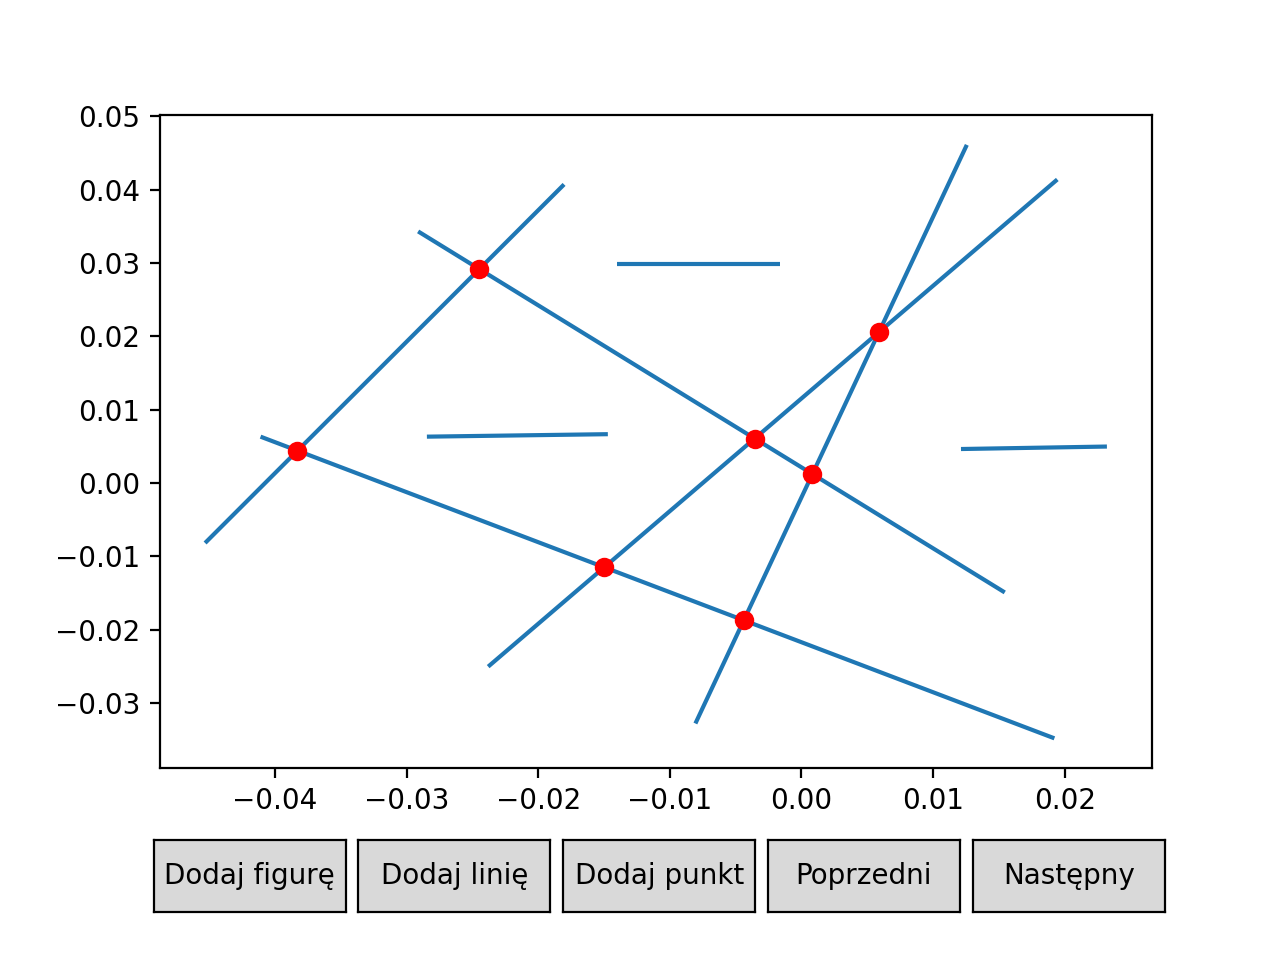

In [164]:
scenki,intersec,info,intersec_lines = Miotła_2(lines)
print("Ilość przecięć",len(intersec_lines))
new_plot = Plot(scenki)
new_plot.draw()
data = pd.DataFrame(data=[[a,b.line1,b.line2] for a,b in info.items()], columns=['Point', 'Line1', 'Line2'])

In [165]:
data.head()

,Point,Line1,Line2
0,"(-0.03829522303557025, 0.004411688733131788)","((-0.04531643775201614, -0.008166168811274507)...","((-0.041102728074596785, 0.006325252757352948)..."
1,"(-0.024477432223294925, 0.02916498448523508)","((-0.04531643775201614, -0.008166168811274507)...","((-0.02912692162298388, 0.034297066482843155),..."
2,"(-0.014984564683877051, -0.011476595199629108)","((-0.023804340977822587, -0.02501665900735294)...","((-0.041102728074596785, 0.006325252757352948)..."
3,"(-0.0035546534071794326, 0.00607053103636697)","((-0.023804340977822587, -0.02501665900735294)...","((-0.02912692162298388, 0.034297066482843155),..."
4,"(-0.004380228984346985, -0.018704391771072075)","((-0.008058373235887109, -0.03276788449754902)...","((-0.041102728074596785, 0.006325252757352948)..."


Ilość przecięć 5


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


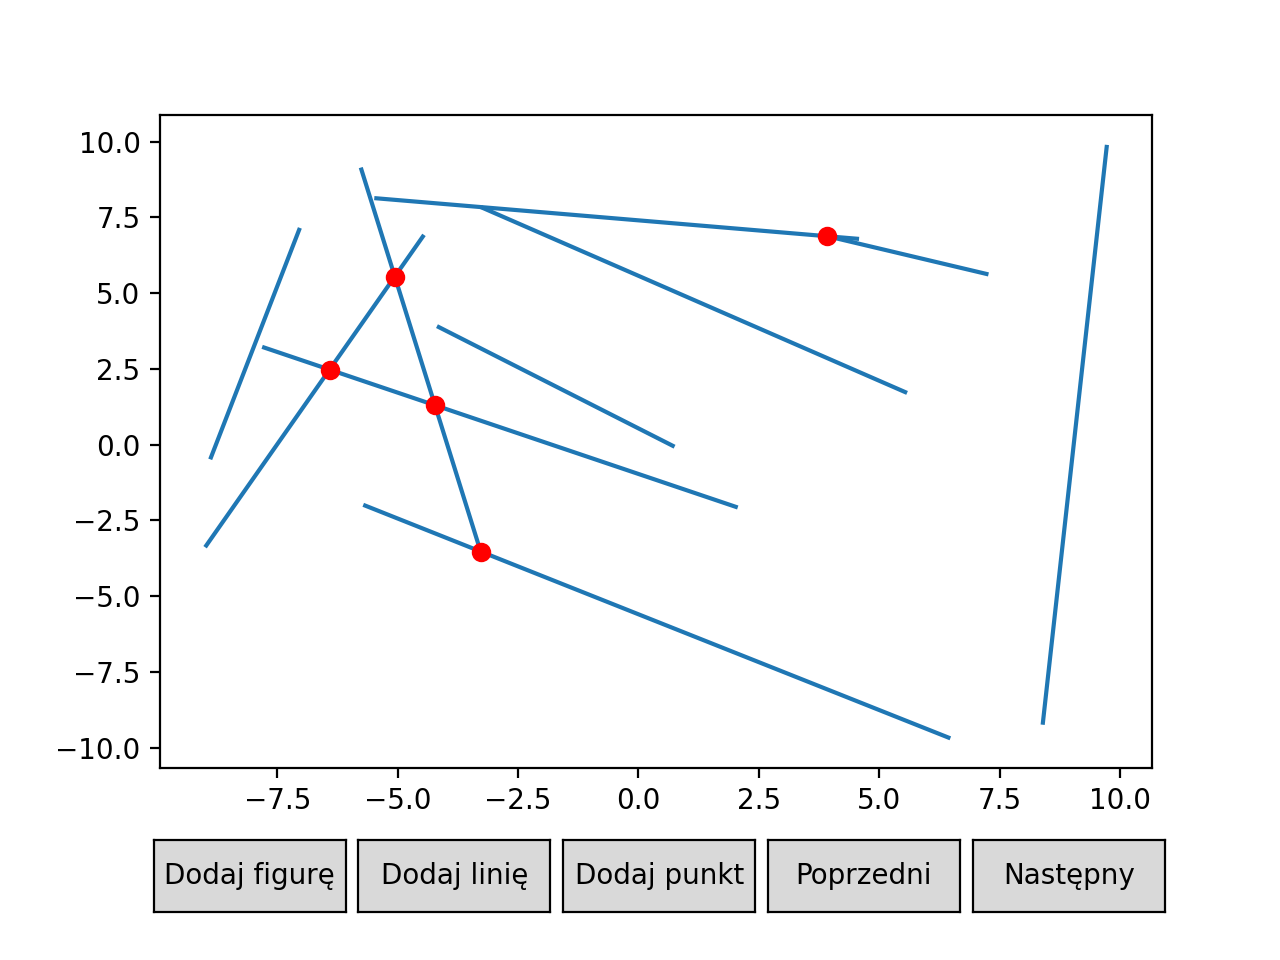

In [166]:
scenki,intersec,info,intersec_lines = Miotła_2(lines1)
print("Ilość przecięć",len(intersec_lines))
new_plot = Plot(scenki)
new_plot.draw()
data_1 = pd.DataFrame(data=[[a,b.line1,b.line2] for a,b in info.items()], columns=['Point', 'Line1', 'Line2'])

In [167]:
data_1.head()

,Point,Line1,Line2
0,"(-6.413359007093915, 2.4768465997507505)","((-8.997611383633314, -3.3812862937316845), (-...","((-7.813024730149907, 3.2279799368031483), (2...."
1,"(-5.058756279102222, 5.5475384835967105)","((-8.997611383633314, -3.3812862937316845), (-...","((-5.765045073069306, 9.141966103532294), (-3...."
2,"(-4.224572327950442, 1.30222996427921)","((-7.813024730149907, 3.2279799368031483), (2....","((-5.765045073069306, 9.141966103532294), (-3...."
3,"(-3.276317841586156, -3.523603527104859)","((-5.713698842681305, -1.983360946958772), (6....","((-5.765045073069306, 9.141966103532294), (-3...."
4,"(3.9251269298722224, 6.876806483006989)","((-5.484664330289073, 8.135082783977566), (4.5...","((3.7545975308587494, 6.941028353745519), (7.2..."


Ilość przecięć 8


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


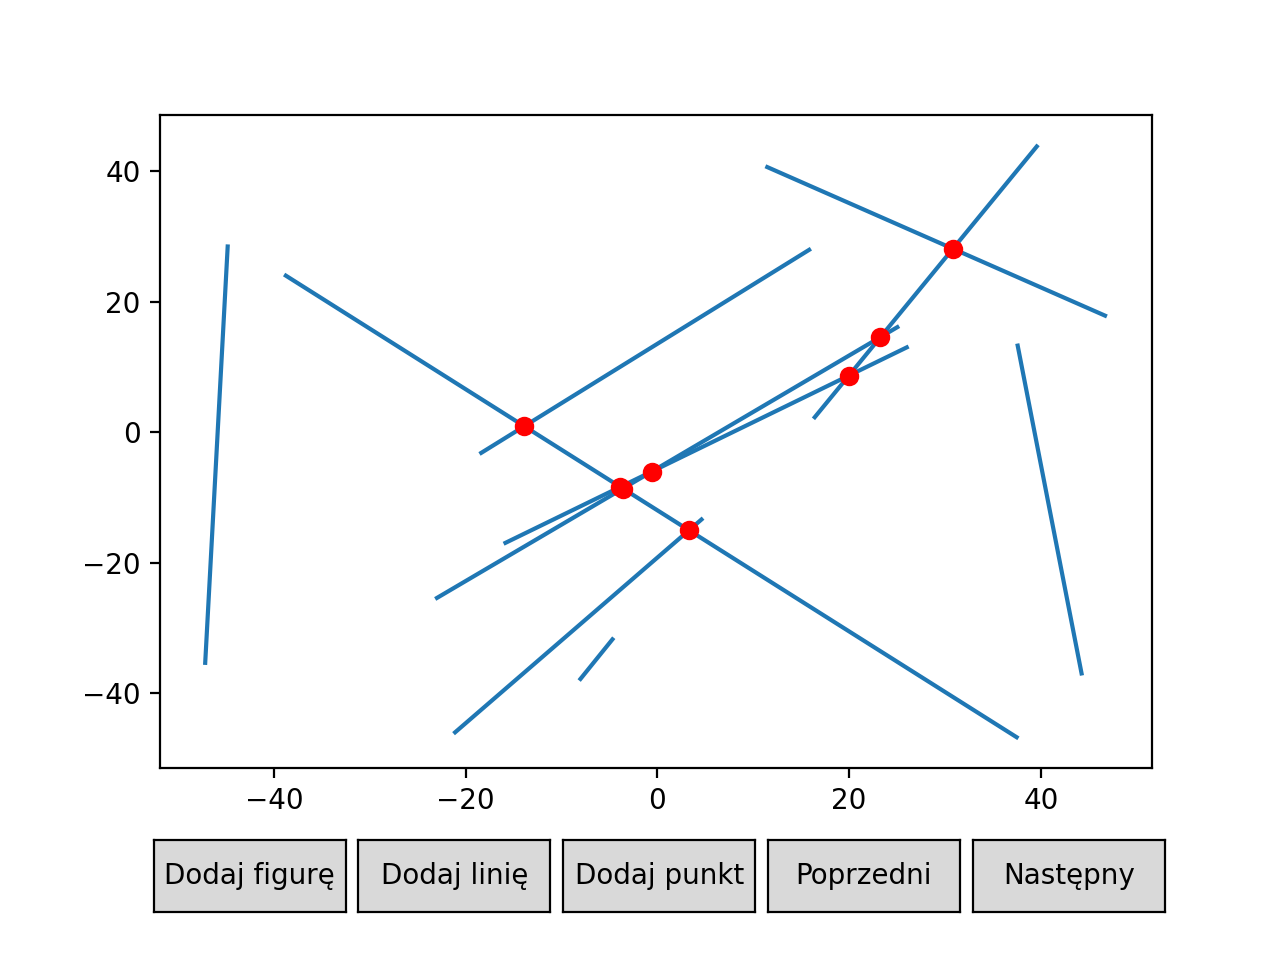

In [168]:
scenki,intersec,info,intersec_lines = Miotła_2(lines2)
print("Ilość przecięć",len(intersec_lines))
new_plot = Plot(scenki)
new_plot.draw()
data_2 = pd.DataFrame(data=[[a,b.line1,b.line2] for a,b in info.items()], columns=['Point', 'Line1', 'Line2'])

In [169]:
data_2.head()

,Point,Line1,Line2
0,"(-3.588743866333154, -8.62548243573223)","((-23.16985643130994, -25.538354876489432), (2...","((-38.92674609485168, 24.151673407252844), (37..."
1,"(-13.879793385173363, 0.9198034490109812)","((-18.54871796708989, -3.3257032048450768), (1...","((-38.92674609485168, 24.151673407252844), (37..."
2,"(-0.5784816139063087, -6.025416616204471)","((-23.16985643130994, -25.538354876489432), (2...","((-16.03434852790472, -17.08159265156558), (26..."
3,"(-3.860651634841224, -8.373279064254858)","((-16.03434852790472, -17.08159265156558), (26...","((-38.92674609485168, 24.151673407252844), (37..."
4,"(3.301663824614489, -15.016561513927254)","((-21.254131966685396, -46.16897896033293), (4...","((-38.92674609485168, 24.151673407252844), (37..."


Ilość przecięć 285


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


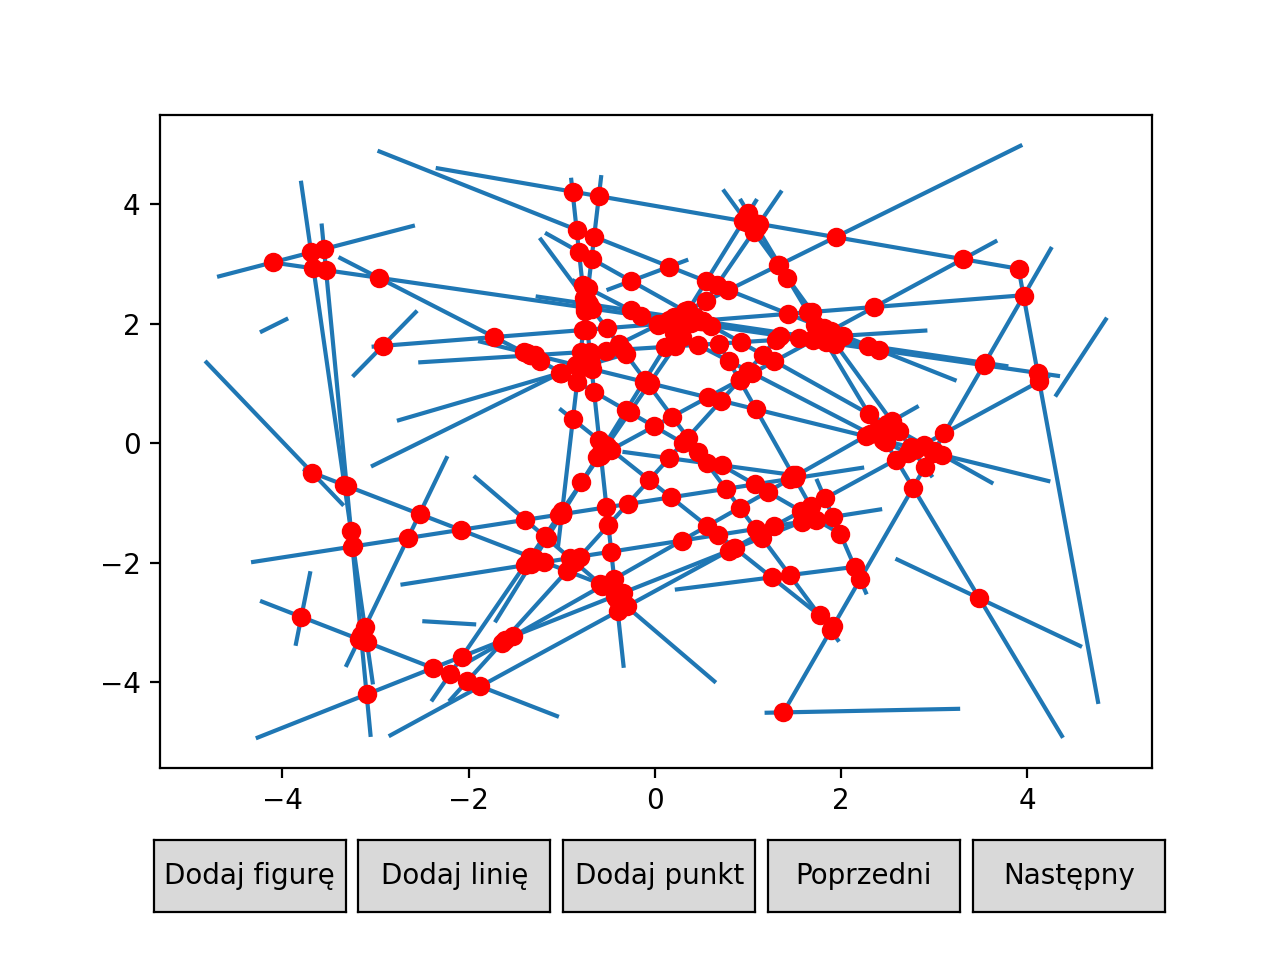

In [170]:
scenki,intersec,info,intersec_lines = Miotła_2(lines3)
print("Ilość przecięć",len(intersec_lines))
new_plot = Plot(scenki)
new_plot.draw()
data_3 = pd.DataFrame(data=[[a,b.line1,b.line2] for a,b in info.items()], columns=['Point', 'Line1', 'Line2'])

In [171]:
data_3.head()

,Point,Line1,Line2
0,"(-2.380724916143316, -3.7606350027277626)","((-4.285964863642084, -4.93761602784156), (1.7...","((-4.2401450416407, -2.635958228823637), (-1.0..."
1,"(-4.10642379010593, 3.0293453816140827)","((-4.70205901180014, 2.7881523961070487), (-2....","((-4.1386450743723024, 3.0365938620685444), (4..."
2,"(-3.7968908185322965, -2.904062097782024)","((-3.8590156566116898, -3.3883633278410796), (...","((-4.2401450416407, -2.635958228823637), (-1.0..."
3,"(-3.691431652550023, 3.1973898305879906)","((-4.70205901180014, 2.7881523961070487), (-2....","((-3.801648425637402, 4.397445553404818), (-3...."
4,"(-2.0856591447371957, -1.4477018384069127)","((-4.337031657631211, -1.9899800612392005), (2...","((-3.7800609864742887, -0.42948166352527384), ..."


Ilość przecięć 12


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


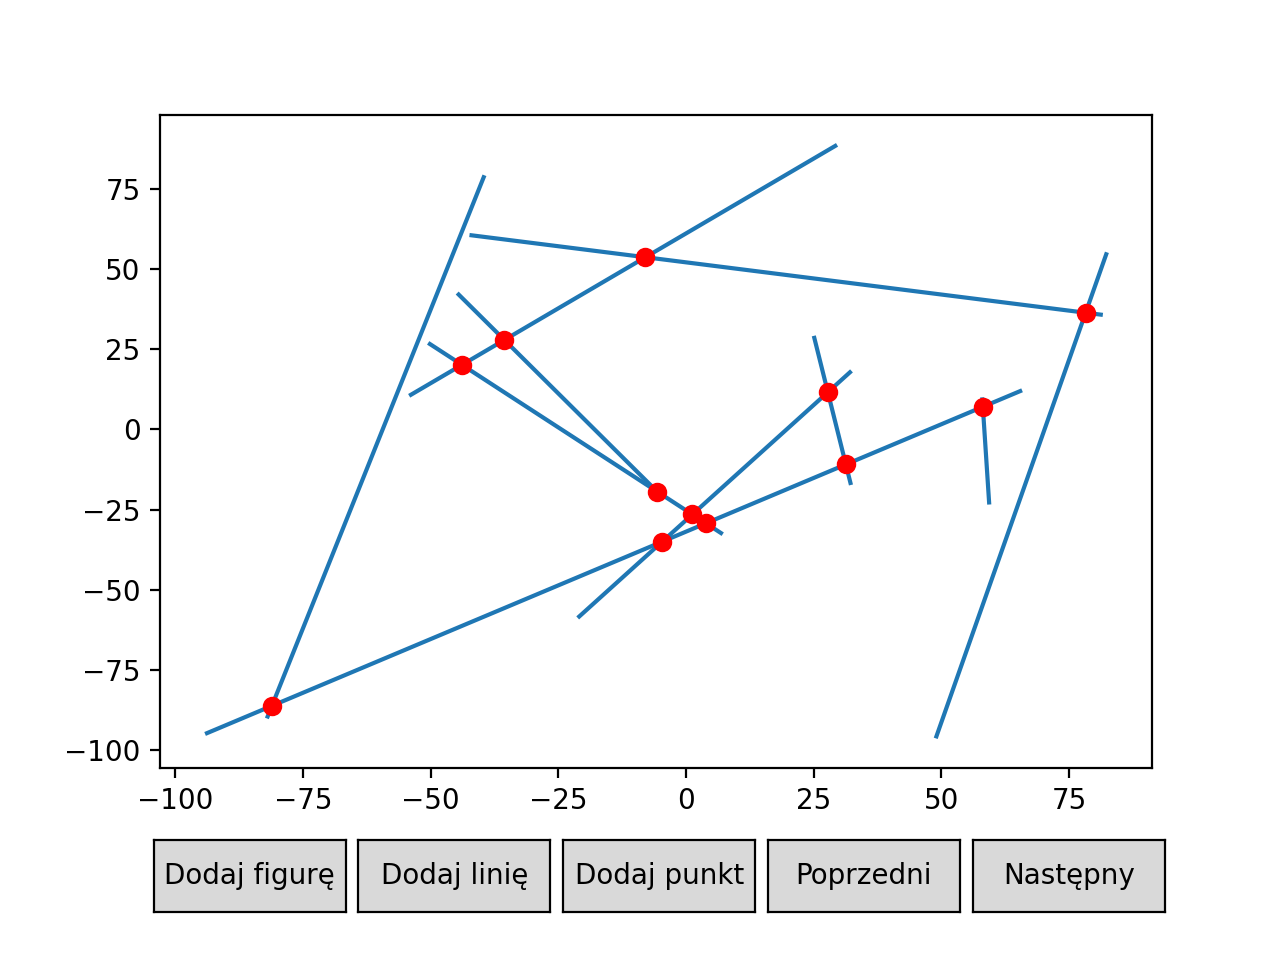

In [172]:
scenki,intersec,info,intersec_lines = Miotła_2(lines4)
print("Ilość przecięć",len(intersec_lines))
new_plot = Plot(scenki)
new_plot.draw()
data_4 = pd.DataFrame(data=[[a,b.line1,b.line2] for a,b in info.items()], columns=['Point', 'Line1', 'Line2'])

In [175]:
data_4.head()

,Point,Line1,Line2
0,"(-81.06830092981227, -86.25591944161559)","((-82.05403536597589, -90.17687966508763), (-3...","((-94.15283774134417, -95.02675133719269), (65..."
1,"(-43.850276483510406, 20.161664401162326)","((-54.18863086907402, 10.499317293790583), (29...","((-50.46775510564221, 27.010609190540634), (7...."
2,"(-5.6322801599703896, -19.393120997791577)","((-50.46775510564221, 27.010609190540634), (7....","((-44.787868997690694, 42.5646861302983), (-4...."
3,"(3.924109018646269, -29.28377355710016)","((-94.15283774134417, -95.02675133719269), (65...","((-50.46775510564221, 27.010609190540634), (7...."
4,"(-35.53889404045815, 27.92957978806635)","((-54.18863086907402, 10.499317293790583), (29...","((-44.787868997690694, 42.5646861302983), (-4...."


Ilość przecięć 1


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


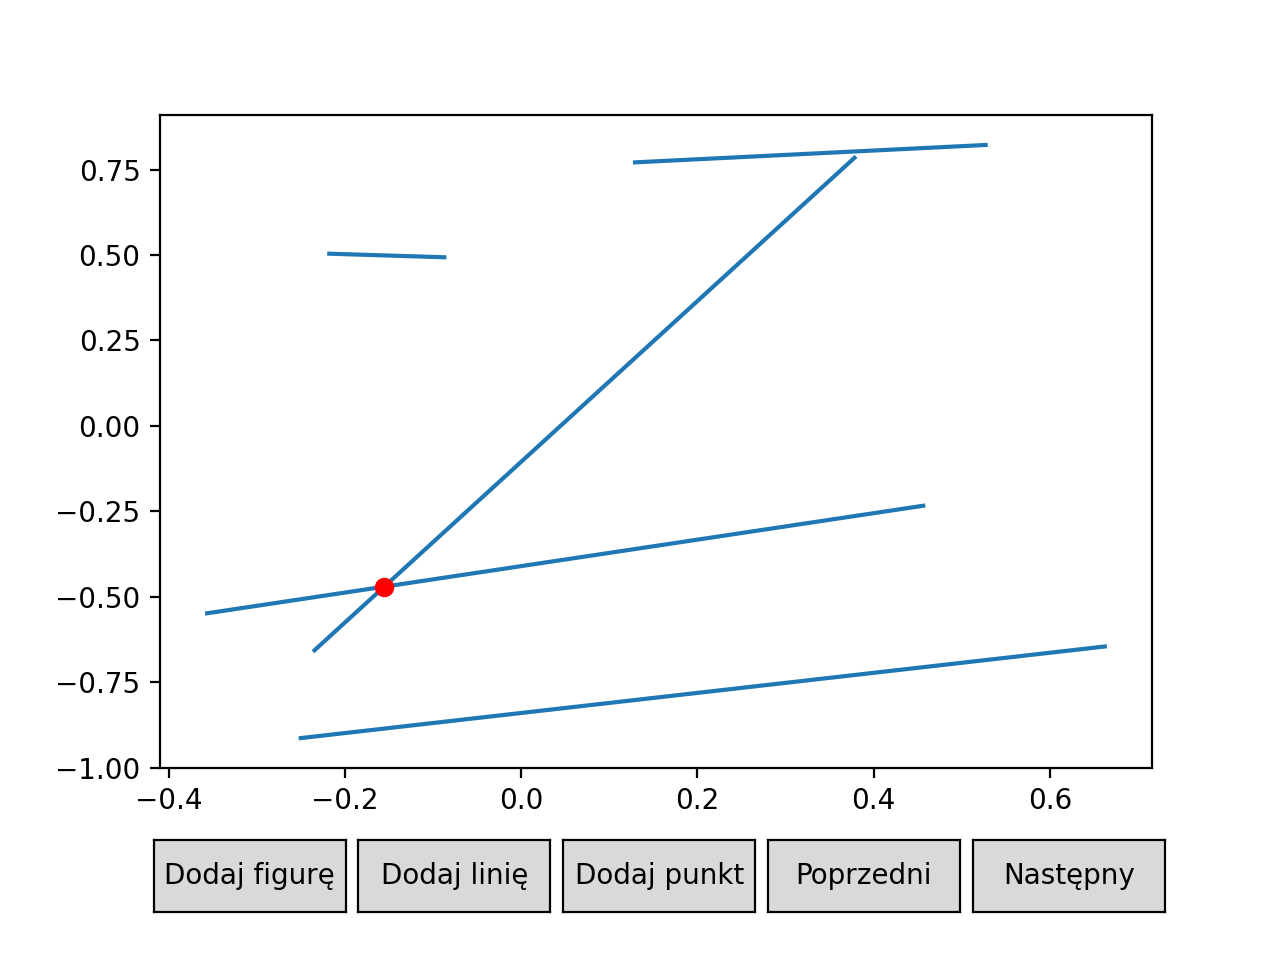

In [183]:
scenki,intersec,info,intersec_lines = Miotła_2(lines5)
print("Ilość przecięć",len(intersec_lines))
new_plot = Plot(scenki)
new_plot.draw()
data_5 = pd.DataFrame(data=[[a,b.line1,b.line2] for a,b in info.items()], columns=['Point', 'Line1', 'Line2'])

In [177]:
data_5.head()

,Point,Line1,Line2
0,"(-0.15529482272333756, -0.47019204026815536)","((-0.23615550391675066, -0.6603098955614515), ...","((-0.3585563828320044, -0.5488871524853765), (..."


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


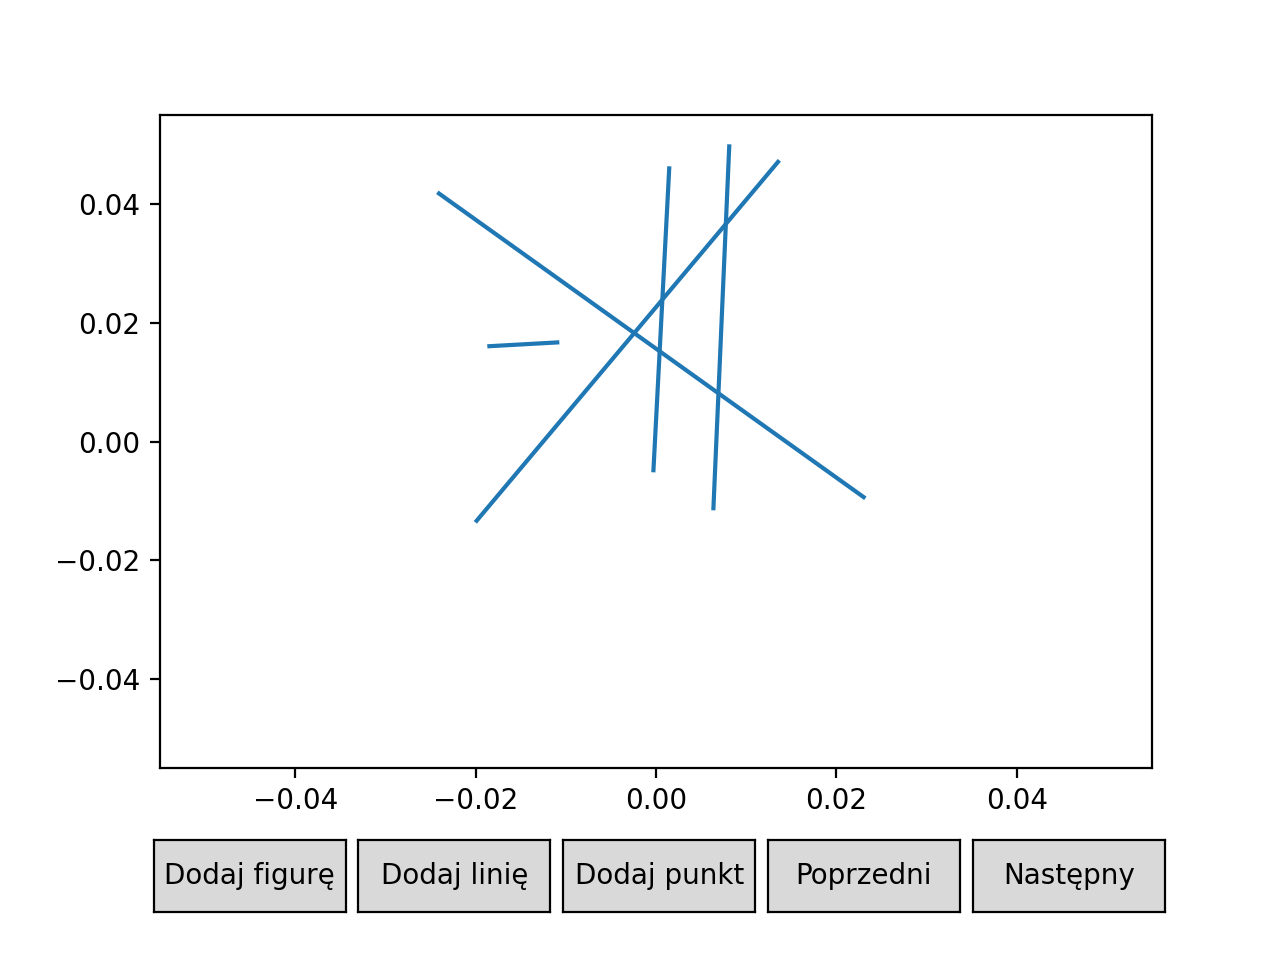

In [23]:
plot = Plot()
plot.draw()

In [24]:
lines6 = get_lines(plot)

Ilość przecięć 5


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


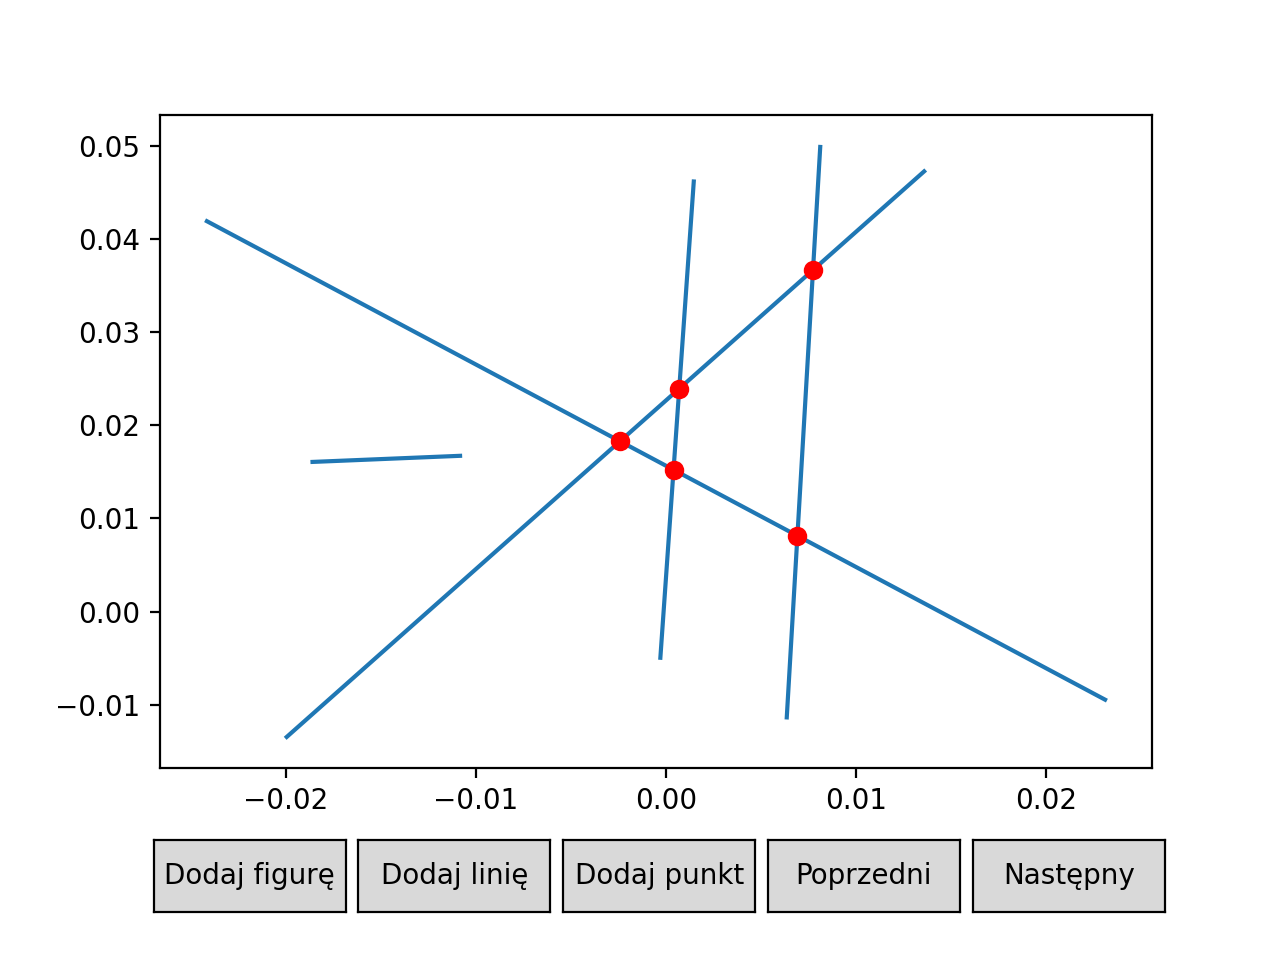

In [182]:
scenki,intersec,info,intersec_lines = Miotła_2(lines6)
print("Ilość przecięć",len(intersec_lines))
new_plot = Plot(scenki)
new_plot.draw()
data_6 = pd.DataFrame(data=[[a,b.line1,b.line2] for a,b in info.items()], columns=['Point', 'Line1', 'Line2'])

In [180]:
data_6.head()

,Point,Line1,Line2
0,"(-0.0024136815842679565, 0.018284421312962807)","((-0.020034179687500007, -0.0136004518995098),...","((-0.02424788936491936, 0.042006165747549035),..."
1,"(0.00040554490426443046, 0.015221476646683461)","((-0.0002962764616935565, -0.00517520680147058...","((-0.02424788936491936, 0.042006165747549035),..."
2,"(0.000705124326416161, 0.023928003602968158)","((-0.0002962764616935565, -0.00517520680147058...","((-0.020034179687500007, -0.0136004518995098),..."
3,"(0.00692418519621089, 0.008139309039778997)","((0.006356949344758056, -0.011578393075980381)...","((-0.02424788936491936, 0.042006165747549035),..."
4,"(0.007744854772647186, 0.036666628323621636)","((0.006356949344758056, -0.011578393075980381)...","((-0.020034179687500007, -0.0136004518995098),..."


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


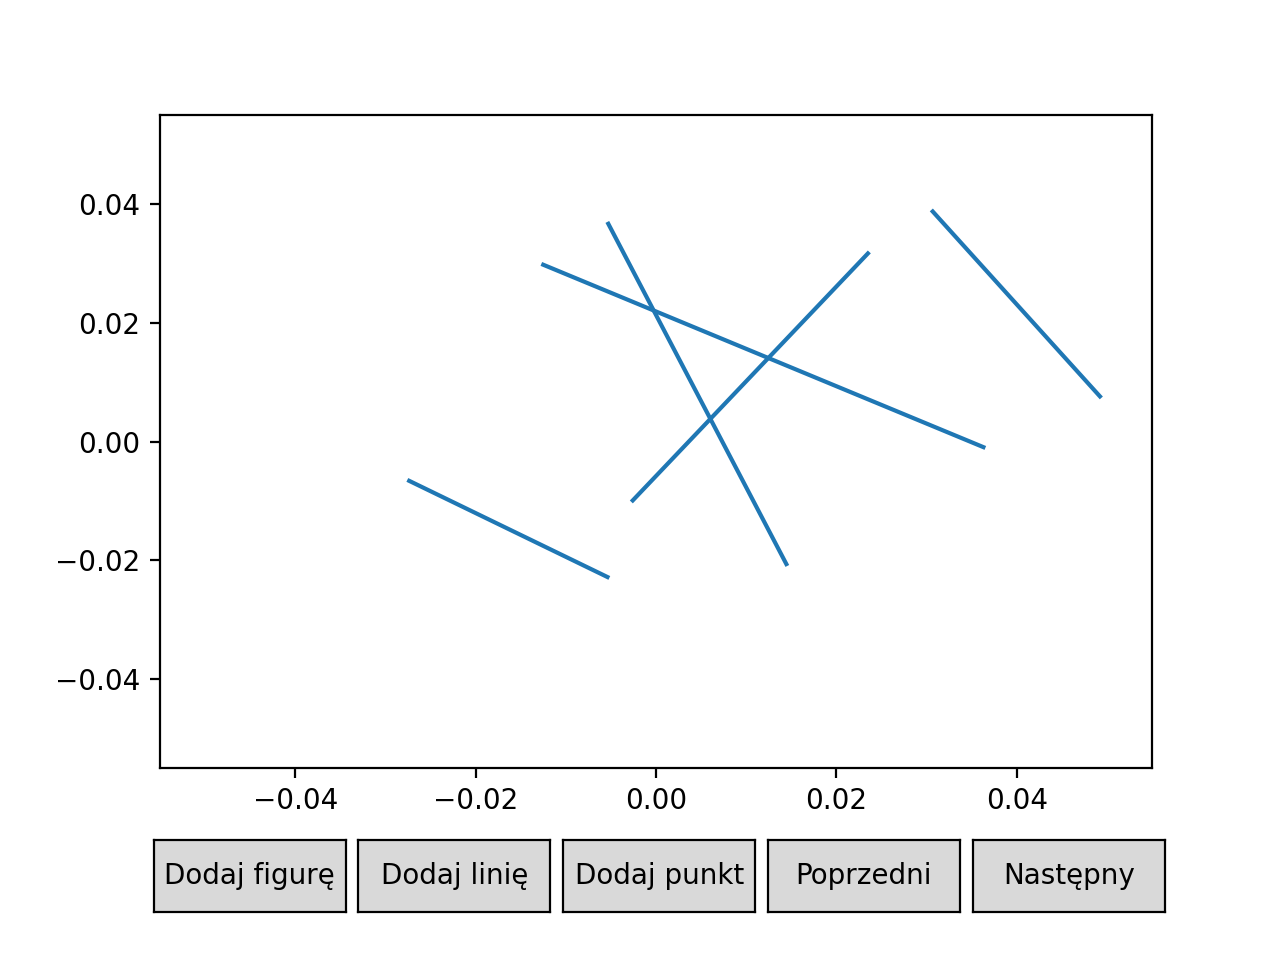

In [26]:
plot = Plot()
plot.draw()

In [27]:
lines7 = get_lines(plot)

Ilość przecięć 3


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_66103/2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


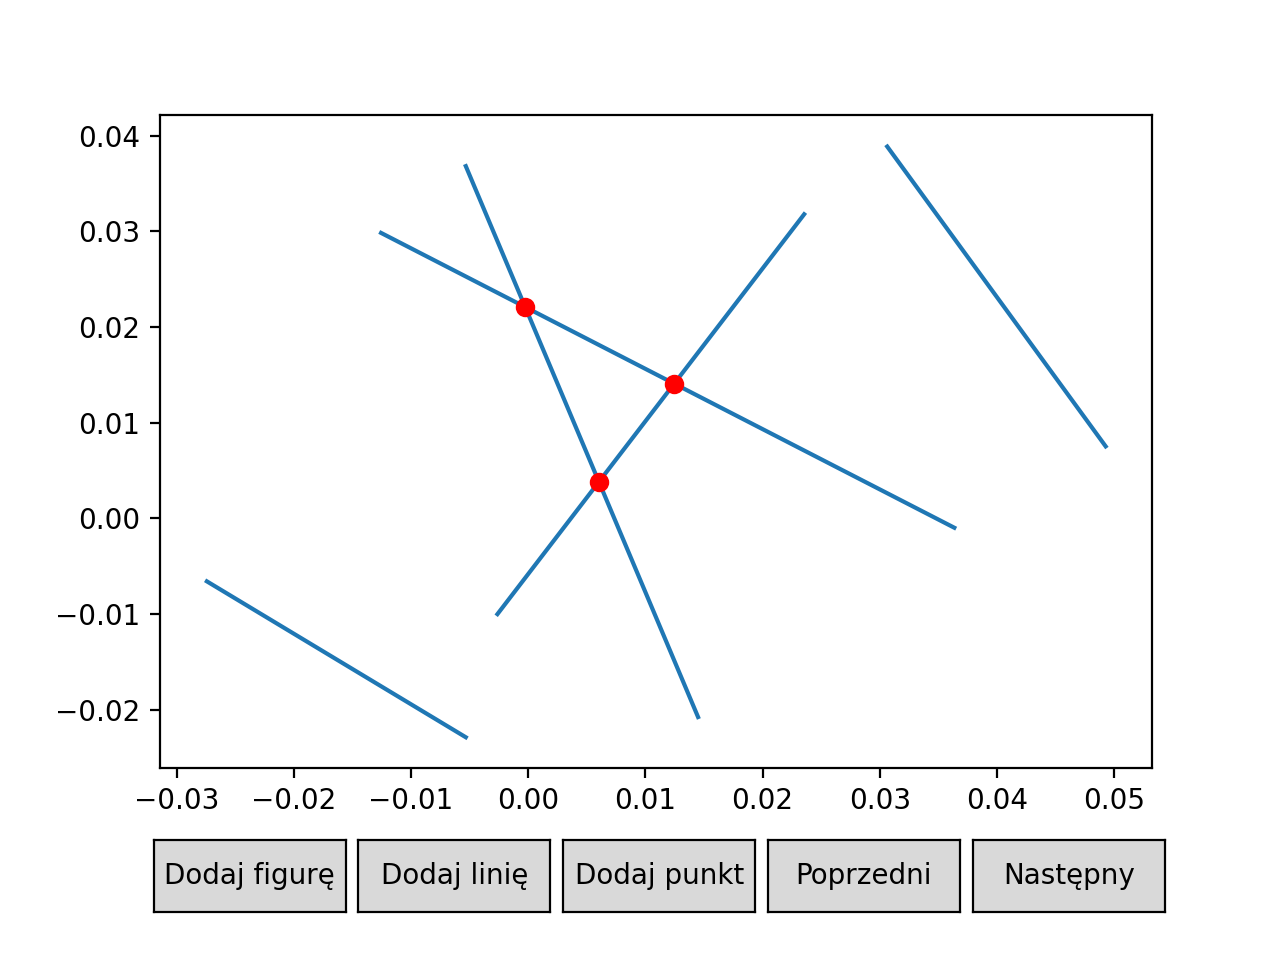

In [181]:
scenki,intersec,info,intersec_lines = Miotła_2(lines7)
print("Ilość przecięć",len(intersec_lines))
new_plot = Plot(scenki)
new_plot.draw()
data_7 = pd.DataFrame(data=[[a,b.line1,b.line2] for a,b in info.items()], columns=['Point', 'Line1', 'Line2'])

In [161]:
data_7.head()

,Point,Line1,Line2
0,"(-0.00025898778308329, 0.022092463345942323)","((-0.012715631300403235, 0.029937002144607858)...","((-0.005397082913306456, 0.0370142080269608), ..."
1,"(0.012457281278224654, 0.014084426037416827)","((-0.0027357925907258163, -0.01016716452205882...","((-0.012715631300403235, 0.029937002144607858)..."
2,"(0.006030741726818515, 0.0038262118498658343)","((-0.0027357925907258163, -0.01016716452205882...","((-0.005397082913306456, 0.0370142080269608), ..."
